# Transient Universe: MCMC Sampling

### WIP - Unfinished!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pymc3 as pm
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [11]:
data = np.load('../solutions/transient.npy')

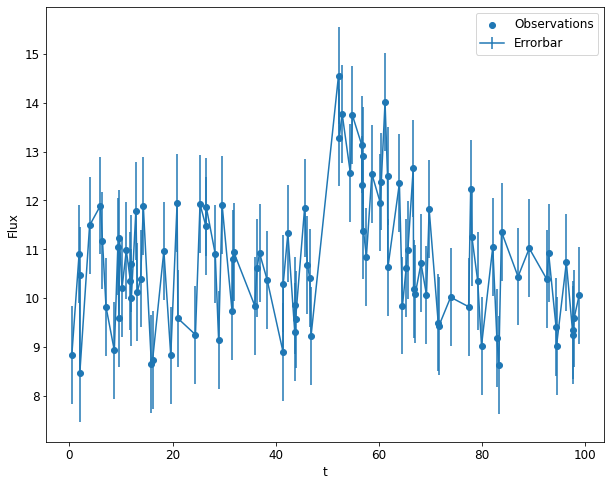

In [15]:
#Unpacking and visualizing data

#t, flux, flux_err = data.T

t = data[:, 0]
flux = data[:, 1]
flux_err = data[:, 2]

plt.scatter(t, flux, label='Observations')
plt.errorbar(t, flux, yerr=flux_err, label='Errorbar')
plt.xlabel('t')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [25]:
t, y, yerr = data.T
t.shape

(100,)

Burst model approximation in which signal is:

$y = b$ if  $t < t_{0}$

$y = b + A\cdot \exp[-\alpha(t-t_{0}])$ if  $t \geq t_{0}$

In [20]:
#Function modeling Signal: Noise + Exponential decay
def fun_model(parameters, t):

    b, t_0, A, alpha = parameters

    return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))

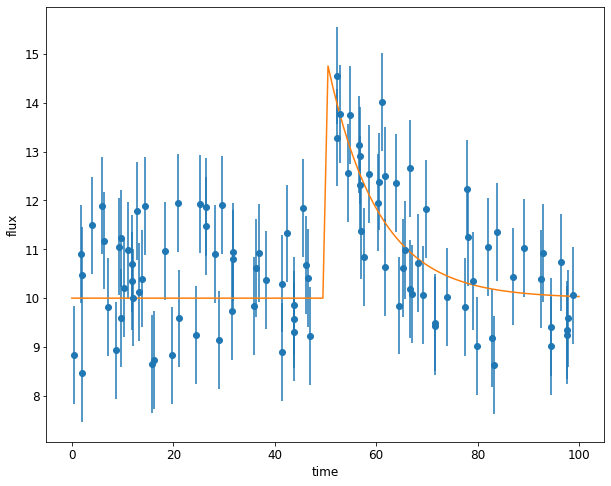

In [21]:
#Eyeball estimate
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1

theta_quick= np.array([b_quick, t0_quick, A_quick, alpha_quick])

#Evaluating the function
ygrid = fun_model(theta_quick, tgrid)

plt.errorbar(t, flux ,yerr=flux_err, fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid, ygrid);

## PYMC3

In [ ]:
with pm.Model () as model:
    #Priors
    b = pm.Uniform('b', 0, 50)
    t_0 = pm.Uniform('t_0', 0, 100)
    A = pm.Uniform('A', 0, 50)
    alpha = pm.Uniform('alpha', -5, 5)      #uniform in Log

    #Likelihood function
    f = model.marginal_likelihood('burst', fun_model([b, t_0, A, alpha], t=t), observed=flux)
    model.observed_RVs('t', t)
    trace = pm.sample(draws=250, cores=4, progressbar=True)

In [ ]:
#This pipeline works, check if samples are from posterior or from prior!

#Gathering samples
b_samples = trace.get_values('b');
t_0_samples = trace.get_values('t_0');
A_samples = trace.get_values('A');
alpha_samples = trace.get_values('alpha');

plt.hist(b_samples, bins=20);

print('It does not draw from the posterior!!!')



## EMCEE

In [2]:
b_prior = stats.uniform(0, 50)
t_0_prior = stats.uniform(0, 100)
A_prior = stats.uniform(0, 50)
alpha_prior = stats.uniform(-5, 5)
Nsamples = 1000

In [3]:
a = np.log(b_prior.rvs(Nsamples))

In [4]:
a

array([ 3.23811959,  2.25468303,  3.01555528,  2.60823359,  1.77306771,
        3.30070312,  2.77550895,  3.5428143 ,  2.30463668,  3.15935647,
        3.24679793,  3.24495158,  3.40296573,  2.74446257,  3.79669693,
        1.59299216,  3.01375476,  3.39330539,  1.17709725,  3.67556239,
        2.91102193,  2.76408513,  0.51131701,  3.62447193,  2.7074639 ,
        3.62673981,  3.21156002,  3.55232061,  3.08057297,  2.58308309,
        2.63930624,  3.77046962,  3.73059521,  2.97192967,  2.32763917,
        2.88753871,  3.39330437,  0.72125468,  3.72120541,  3.65919881,
        2.95700849,  3.29453776,  0.23503464,  2.81843145,  1.602976  ,
        3.84114973,  3.23449238,  3.19677976,  3.68663914,  1.5339221 ,
        3.88590111,  3.264684  ,  3.31282118,  3.76132821,  2.08909963,
        2.71419047,  3.34019255,  3.78127215,  3.30173436,  2.82375448,
        3.4914631 ,  2.43217974,  3.66455511,  2.77948204,  3.50308851,
        1.96679721,  3.89773348,  2.77369817,  2.65881448,  0.21

In [22]:
def loglike(flux, flux_theoretical):
    
    #Gaussian Log-Likelihood
    logL = -0.5 * np.sum(((flux - flux_theoretical)**2 / (flux_err)**2))

    return logL

def logprior(priors, Nsamples):
    return np.log(np.prod(priors.rvs(Nsamples)))


def logposterior(theta, data, model, priors):
    t, flux, flux_err = data.T
    flux_theoretical = model(theta, t)
    
    draws = t.shape

    logposterior = loglike(flux, flux_theoretical) + logprior(priors, draws)

    return logposterior

In [23]:
b_prior = stats.uniform(0, 50)
t_0_prior = stats.uniform(0, 100)
A_prior = stats.uniform(0, 50)
alpha_prior = stats.uniform(-5, 5)

#Number of parameters
ndim = 4

#Sampler walkers
nwalkers = 5 * ndim

#Steps that each walker takes -> Number of samples per walker
steps = 1000 

priors = [b_prior, t_0_prior, A_prior, alpha_prior]

starting_guesses = theta_quick + 1e-1* np.random.randn(nwalkers, ndim)


In [24]:
args = {
    'data' : data,
    'model' : fun_model,
    'priors' : priors
}

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=args)
sampler.run_mcmc(starting_guesses, steps)

print("done")

emcee: Exception while calling your likelihood function:
  params: [10.01921512 50.06261553  5.03980587  0.10187849]
  args: {'data': array([[ 0.46954762,  8.83485016,  1.        ],
       [ 1.87898004, 10.90082649,  1.        ],
       [ 2.01075462, 10.46566244,  1.        ],
       [ 2.02183974,  8.46375631,  1.        ],
       [ 3.91877923, 11.48825219,  1.        ],
       [ 6.02254716, 11.89588918,  1.        ],
       [ 6.41474963, 11.17877957,  1.        ],
       [ 7.10360582,  9.82007516,  1.        ],
       [ 8.71292997,  8.92924738,  1.        ],
       [ 9.39405108, 11.05445173,  1.        ],
       [ 9.60984079,  9.59682305,  1.        ],
       [ 9.71012758, 11.22244507,  1.        ],
       [10.20448107, 10.20827498,  1.        ],
       [11.03751412, 10.97663904,  1.        ],
       [11.82744259, 10.3563664 ,  1.        ],
       [11.8727719 , 10.70657317,  1.        ],
       [12.01965612, 10.01050002,  1.        ],
       [12.89262977, 11.78587049,  1.        ],
  

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_18076/2043068974.py", line 13, in logposterior
    t, flux, flux_err = data.T
AttributeError: 'str' object has no attribute 'T'


AttributeError: 'str' object has no attribute 'T'